In [81]:
import pandas as pd
import numpy as np 
import scipy.stats as st
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns

In [13]:
# Data 
dat_file = 'quotedata.dat'
df = pd.read_csv(dat_file, skiprows=2, header=0)
df['Expiration Date'] = pd.to_datetime(df['Expiration Date'])

# Add market mids
df['Call_mid'] = (df['CBid'] + df['CAsk']) / 2
df['Put_mid'] = (df['PBid'] + df['PAsk']) / 2

# Add time to maturity
quote_date = datetime(2019, 2, 8)
spy_spot = 2707.88
def calculate_tau(expiration_date, quote_date=quote_date):
    tau = (expiration_date - quote_date).days / 365.0
    return tau

df['tau'] = df['Expiration Date'].apply(lambda x: calculate_tau(x))

In [71]:
# Volatility functions
def BS_Call_Option_Price(S_0, K, sigma, tau, r=0, q=0, CP="c"):
    d1    = (np.log(S_0 / float(K)) + (r-q + 0.5 * np.power(sigma,2.0)) * tau) / float(sigma * np.sqrt(tau))
    d2    = d1 - sigma * np.sqrt(tau)
    if str(CP).lower()=="c" or str(CP).lower()=="1":
        value = np.exp(-q*tau) * st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * tau)
    elif str(CP).lower()=="p" or str(CP).lower()=="-1":
        value = st.norm.cdf(-d2) * K * np.exp(-r * tau) - st.norm.cdf(-d1)*S_0*np.exp(-q*tau)
    return value

# Vega, dV/dsigma
def dV_dsigma(S_0,K,sigma,tau,r,q):
    #parameters and value of Vega
    d1    = (np.log(S_0 / float(K)) + (r-q + 0.5 * np.power(sigma,2.0)) * tau) / float(sigma * np.sqrt(tau))
    value = st.norm.pdf(d1) * np.sqrt(tau) * S_0 * np.exp(-q * tau)
    return value

# Implied Vol with Newton - Raphson
def ImpliedVolatility(S_0,K,sigma,tau,r,q, V_market, max_iter=10000, CP="c"):
    error    = 1e10; # initial error
    #Handy lambda expressions
    optPrice = lambda sigma: BS_Call_Option_Price(S_0,K,sigma,tau,r,q,CP)
    vega = lambda sigma: dV_dsigma(S_0,K,sigma,tau,r,q)
    
    # While the difference between the model and the arket price is large
    # follow the iteration
    n = 1.0 
    while error>10e-12 and n<max_iter:
        g = optPrice(sigma) - V_market
        g_prim = vega(sigma)
        sigma_new = sigma - g / (g_prim)
    
        #error=abs(sigma_new-sigma)
        error=abs(g)
        sigma=sigma_new
        
        #print('iteration {0} with error = {1}'.format(n,error))
        
        n= n+1
    return sigma


# Calibrate for r and q 
def put_call_parity(Call, Put, r, q, tau, K, spy_spot):
    lhs = Call - Put
    F = spy_spot * np.exp((r - q)*tau)
    rhs = np.exp(-r*tau)*(F - K)
    diff = lhs - rhs 
    return diff

def objective(params, data, spy_spot=spy_spot):
    r, q = params
    total_squared_error = 0

    for index, row in data.iterrows():
        Call = row['Call_mid']
        Put = row['Put_mid']
        tau = row['tau']
        K = row['Strike']

        diff = put_call_parity(Call, Put, r, q, tau, K, spy_spot)
        total_squared_error += diff ** 2

    return total_squared_error

In [76]:
# Market implied r and q
initial_guess = [0.05, 0.02]
result = minimize(objective, initial_guess, args=(df, spy_spot), method='L-BFGS-B')
if result.success:
    optimized_r, optimized_q = result.x
    print(f"Market implied interest rate (r): {optimized_r}")
    print(f"Market implied dividend yield (q): {optimized_q}")
else:
    print("Optimization failed")

r_imp = optimized_r
q_imp = optimized_q    

Market implied interest rate (r): 0.02687497644389257
Market implied dividend yield (q): 0.021766420970007576


In [83]:
# Call IV
df['call_iv'] = df.apply(lambda row: ImpliedVolatility(S_0=spy_spot, K=row['Strike'], sigma=0.25, tau=row['tau'], r=r_imp, q=q_imp, V_market=row['Call_mid']), axis=1)
df['put_iv'] = df.apply(lambda row: ImpliedVolatility(S_0=spy_spot, K=row['Strike'], sigma=0.25, tau=row['tau'], r=r_imp, q=q_imp, V_market=row['Put_mid'], CP="p"), axis=1)
df['implied_vol'] = (df['call_iv'] + df['put_iv']) / 2

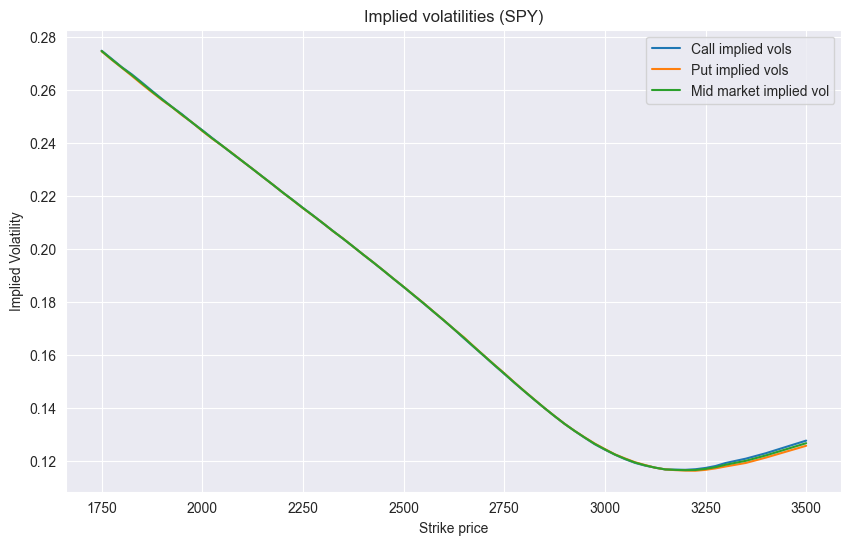

In [86]:
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))

plt.plot(df['Strike'], df['call_iv'], label='Call implied vols')
plt.plot(df['Strike'], df['put_iv'], label='Put implied vols')
plt.plot(df['Strike'], df['implied_vol'], label='Mid market implied vol')
plt.xlabel('Strike price')
plt.ylabel('Implied Volatility')
plt.title('Implied volatilities (SPY)')
plt.legend()
plt.show()

In [91]:
# SVI Model Fitting 
# x = ln(K/S)
# Formula: var(x) = a + b * (p * (x - m) + sqrt((x - m)**2 + s**2))

def svi_model(a, b, p, m, s, x):
    return a + b * (p * (x - m) + np.sqrt((x - m)**2 + s**2))

def svi_objective(params, x, implied_vol_sq):
    a, b, p, m, s = params
    model_variance = svi_model(a, b, p, m, s, x)
    squared_error = np.sum((model_variance - implied_vol_sq)**2)
    return squared_error

def calibrate_svi(x, implied_vol_sq):
    initial_guess = [0.1, 0.1, 0.0, 0.0, 0.1]

    # Bounds for the parameters: a > 0, b > 0, -1 <= rho <= 1, sigma > 0
    bounds = [(0, None), (0, None), (-1, 1), (None, None), (0, None)]

    # Minimize the objective function to find the best-fit SVI parameters
    result = minimize(svi_objective, initial_guess, args=(x, implied_vol_sq), bounds=bounds)

    if result.success:
        return result.x
    else:
        print("Optimization failed.")
        return None


In [95]:
# Optimization 
df['LogMoneyness'] = np.log(df['Strike'] / spy_spot)
df['implied_vol_sq'] = df['implied_vol'] ** 2
svi_params = calibrate_svi(df['LogMoneyness'].values, df['implied_vol_sq'].values)
a, b, p, m, s = svi_params

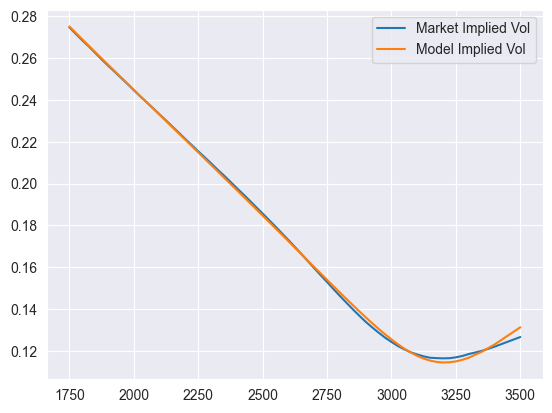

In [103]:
df['model_iv'] = np.sqrt(df['LogMoneyness'].apply(lambda x: svi_model(a, b, p, m, s, x)))

# Model vs Market
plt.plot(df['Strike'], df['implied_vol'], label='Market Implied Vol')
plt.plot(df['Strike'], df['model_iv'], label='Model Implied Vol')
plt.legend()
plt.show()

In [100]:
df.head()

,Expiration Date,Calls,CBid,CAsk,Strike,Puts,PBid,PAsk,Call_mid,Put_mid,tau,call_iv,put_iv,implied_vol,LogMoneyness,implied_vol_sq,model_iv
0,2019-12-20,SPX191220C01750000,955.0,958.7,1750.0,SPX191220P01750000,8.9,9.5,956.85,9.20,0.863014,0.274740,0.274510,0.274625,-0.436550,0.075419,0.275027
1,2019-12-20,SPX191220C01775000,931.4,935.1,1775.0,SPX191220P01775000,9.7,10.3,933.25,10.00,0.863014,0.271670,0.271313,0.271492,-0.422366,0.073708,0.271967
2,2019-12-20,SPX191220C01800000,907.9,911.5,1800.0,SPX191220P01800000,10.6,11.2,909.70,10.90,0.863014,0.268547,0.268328,0.268438,-0.408379,0.072059,0.268916
3,2019-12-20,SPX191220C01825000,884.5,888.1,1825.0,SPX191220P01825000,11.5,12.2,886.30,11.85,0.863014,0.265824,0.265265,0.265545,-0.394586,0.070514,0.265876
4,2019-12-20,SPX191220C01850000,861.1,864.7,1850.0,SPX191220P01850000,12.5,13.2,862.90,12.85,0.863014,0.262761,0.262121,0.262441,-0.380980,0.068875,0.262844
